# Assignment One &mdash; CSI 5180: Machine Learning for Bioinformatics

**Student Name:** Steven Sun  
**Student ID:** 300067541

# Loading the Dataset


*   Positive Sequences from [Arabidopsis_tata.fa](https://raw.githubusercontent.com/solovictor/CNNPromoterData/refs/heads/master/Arabidopsis_tata.fa)
*   Positive Sequences from [Arabidopsis_non_tata.fa](https://raw.githubusercontent.com/solovictor/CNNPromoterData/refs/heads/master/Arabidopsis_non_tata.fa)
*   Negative Sequences from [Arabidopsis_non_prom_big.fa](https://raw.githubusercontent.com/solovictor/CNNPromoterData/refs/heads/master/Arabidopsis_non_prom_big.fa)
*   Store each sequence identificator and each corresponding sequence name into a Python dictionary key-value pair.
*   The final datasets object is a dictionary of 3 dictionaries of key-value pairs representating each sequence.







In [ ]:
# Import necessary libraries
import requests

# Define URLs for the datasets
urls = {
    'Arabidopsis_tata': 'https://raw.githubusercontent.com/solovictor/CNNPromoterData/refs/heads/master/Arabidopsis_tata.fa',
    'Arabidopsis_non_tata': 'https://raw.githubusercontent.com/solovictor/CNNPromoterData/refs/heads/master/Arabidopsis_non_tata.fa',
    'Arabidopsis_non_prom_big': 'https://raw.githubusercontent.com/solovictor/CNNPromoterData/refs/heads/master/Arabidopsis_non_prom_big.fa'
}


In [ ]:
# Function to download and read the dataset
def load_fasta(url):
    response = requests.get(url)
    response.raise_for_status()  # Ensure the request was successful
    data = response.text
    sequences = {}
    sequence_id = None
    sequence_lines = []
    for line in data.splitlines():
        if line.startswith('>'):
            if sequence_id is not None:
                sequences[sequence_id] = ''.join(sequence_lines)
            sequence_id = line[1:]  # Remove '>' character
            sequence_lines = []
        else:
            sequence_lines.append(line.strip())
    if sequence_id is not None:
        sequences[sequence_id] = ''.join(sequence_lines)
    return sequences

# Data Encoding


*   Each sequence needs to be transformed into a representation of 4-mers or 6-mers utilizing the sliding window technique, culmulating in a list of strings of k-mers for each sequence.
*   Frequency distributions of each 4-mer or 6-mer need to be analyzed.
*   Prepare k-mers from every sequence of every dictionary of every FASTA dataset for labeling the positive and negative classes.





In [ ]:
# Load datasets
datasets = {name: load_fasta(url) for name, url in urls.items()}

# Example: Accessing sequences from the Arabidopsis_tata dataset
for seq_id, sequence in datasets['Arabidopsis_tata'].items():
    print(f'Sequence ID: {seq_id}')
    print(f'Sequence: {sequence}')
    print(f'Length of a Sequence: {len(sequence)}')
    break  # Remove this line to print all sequences

# Examine the number of sequences from each dataset
print('TATA dictionary size: ' + str(len(datasets['Arabidopsis_tata'])))
print('NON-TATA dictionary size: ' + str(len(datasets['Arabidopsis_non_tata'])))
print('NON-PROM BIG dictionary size: ' + str(len(datasets['Arabidopsis_non_prom_big'])))

Sequence ID: FP000001 AT1G01050_1         :+U  EU:NC; range  -200 to    50.
Sequence: CAAGTATCCTACATAGATTATAGGAGTGACCGCAAAAACACAAACTATGTTTCGTAATAAAAAATAAAGTATTTTTAAAAAGATGTAAATCTTTGTAAATAATTGAGTGGTAGTGTAGTGAGTGTTACGATAATATAAAAGTTTGATCCGTATATCTCGGTGGTGACTCATATATACATTTTACAATCACTTGCTAGACCAACGGGCTTCACTTGTTTCTCTCCCAAAGTTTCTTCATCATCCTTGCGATA
Length of a Sequence: 251
TATA dictionary size: 1497
NON-TATA dictionary size: 5905
NON-PROM BIG dictionary size: 8661


In [ ]:
def generate_kmers(sequence, k):
    """Generate k-mers of length k from the given sequence."""
    return [str(sequence[i:i+k]) for i in range(len(sequence) - k + 1)]

In [ ]:
from collections import Counter
import numpy as np
import itertools

def normalize_dict(d):
    """Normalize the values of a dictionary to sum to 1."""
    total = sum(d.values())  # Compute total sum of values
    return {k: v / total for k, v in d.items()}  # Normalize each value

def encode_kmer_frequencies(sequences, k):
    """Encode a list of sequences into k-mer frequency vectors."""
    kmer_counts = []

    # Show a frequency distribution vector of a given sequence as an example
    given_seq = generate_kmers(sequences[0], k) # first sequence
    given_count = Counter(given_seq)
    given_proportions = normalize_dict(given_count)
    print('Frequency Distribution Vector of a Given Sequence:')
    for kmer_name, proportion in given_proportions.items():
        print(f'{kmer_name} = {proportion}')

    # Process every sequence of a dataset
    for seq in sequences:
        kmers = generate_kmers(seq, k)
        count = Counter(kmers)
        proportions = normalize_dict(count)
        kmer_counts.append(proportions)

    # Get the set of all possible k-mers
    all_kmers = [''.join(p) for p in itertools.product('ACGT', repeat=k)]

    # Create frequency vectors
    frequency_vectors = []
    for count in kmer_counts:
        # Use .get(kmer, 0) to provide a default value of 0 for missing kmers
        freq_vector = [count.get(kmer, 0) for kmer in all_kmers]
        frequency_vectors.append(freq_vector)

    # I recognize the legacy return of all_kmers but it is useful for debugging in the next steps
    return np.array(frequency_vectors), all_kmers

In [ ]:
import numpy as np

def dicts_to__lists(datasets):
  """Convert dictionaries of sequences into lists of postive and negative sequences."""
  positive_sequences = list(datasets['Arabidopsis_tata'].values()) + list(datasets['Arabidopsis_non_tata'].values())
  negative_sequences = list(datasets['Arabidopsis_non_prom_big'].values())
  return positive_sequences, negative_sequences

In [ ]:
def generate_sequences():

    # Create sequences
    positive_sequences, negative_sequences = dicts_to__lists(datasets)
    all_sequences = positive_sequences + negative_sequences

    # Create labels: 1 for positive, 0 for negative
    all_labels = [1] * len(positive_sequences) + [0] * len(negative_sequences)
    return all_sequences, all_labels

In [ ]:
def encoding_4mer_6mer(k):

    # Obtain sequences and labels
    sequences, labels = generate_sequences()

    # Encode sequences into k-mer frequency vectors
    X, kmer_list = encode_kmer_frequencies(sequences, k)

    # Convert labels to a NumPy array
    y = np.array(labels)

    return X, kmer_list, y

# Understanding the Data


*   Class distribution between the positive and negative classes needs to be illustrated.
*   Additional feature analysis are to be displayed.
*   Frequency distribution vector of a given sequence will be shown.
*   T-Distributed Stochastic Neighbor Embedding (t-SNE) will be utilized for dimension reduction, leading to intuitive visualizations of the geometric differences between the positive class and the negative class. Several paramters will be experimented with.



In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# Show all rows of Pandas Dataframes
pd.set_option('display.max_rows', None)

# X: k-mer frequency matrix with type ndarray
# y: labels (1 for positive, 0 for negative) with type ndarray

# Basic Binary Class Distribution Analysis
def plot_class_distribution(labels):
    """Plot the distribution of classes in the dataset."""
    class_counts = pd.Series(labels).value_counts()
    plt.figure(figsize=(6, 4))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
    plt.show()

In [ ]:
# Feature Analysis prints the X dataFrame
def feature_statistics(features):
    """Compute and display summary statistics of the features."""
    stats = features.describe().T
    print("Feature Summary Statistics of every feature:")
    print(stats[['mean', 'std', 'min', '25%', '50%', '75%', 'max']])

In [ ]:
# TSNE Visualization
def plot_examples(X, y):

    plt.figure(figsize=(8, 6))

    # Scatter plot: use labels to color the points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", alpha=0.7, edgecolors="k")

    # Add colorbar
    plt.colorbar(scatter, label="Labels")

    # Labels and title
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("TSNE: 2D Feature Space with Labels")
    plt.grid(True)

    plt.show()

In [ ]:
from sklearn.manifold import TSNE

# Experiment with various parameters such as changing the k-value, perplexity, and early exaggeration.
X, kmer_list, y = encoding_4mer_6mer(4)
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=5, early_exaggeration=4).fit_transform(X)

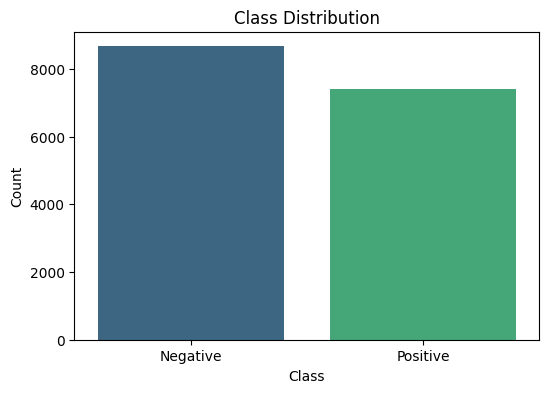

In [ ]:
plot_class_distribution(y) # Scanning the class distribution for data imbalance.

## The negative and positve Classes are well balanced. There is no need to oversample or undersample any majority or minority classes.

In [ ]:
feature_statistics(X)

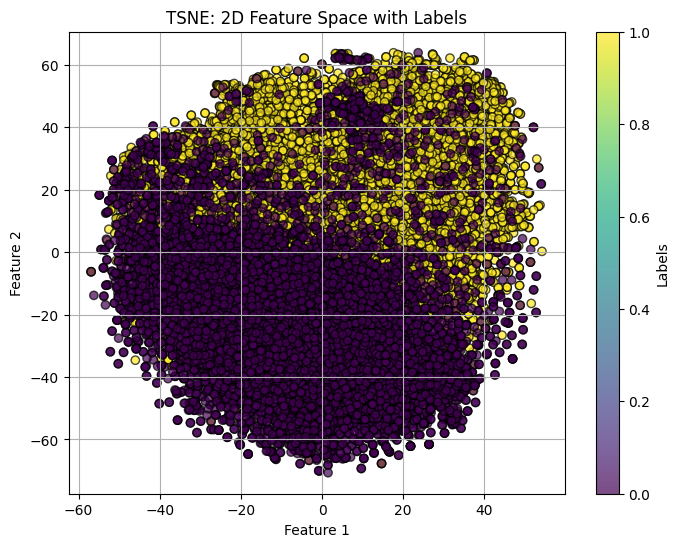

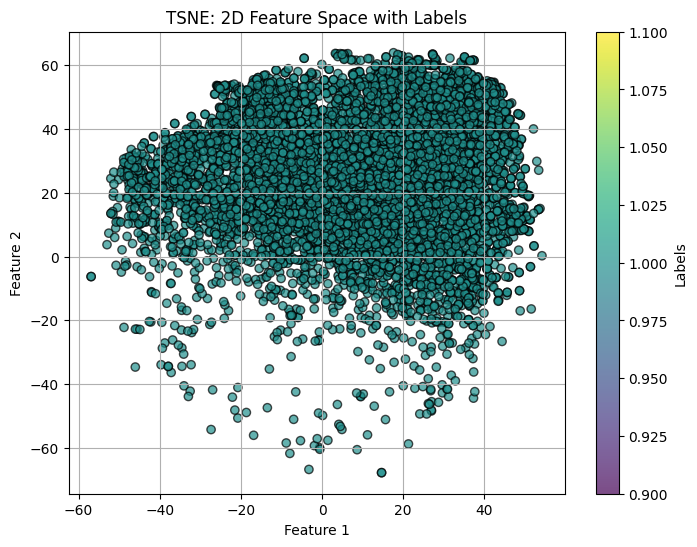

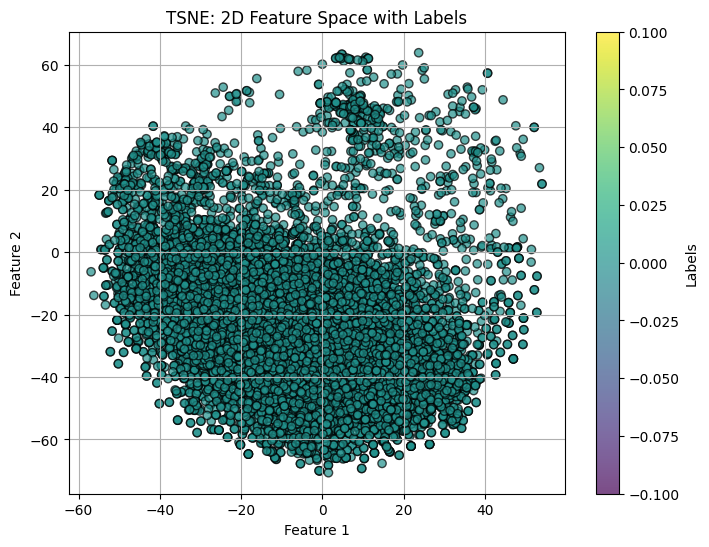

In [ ]:
plot_examples(X_embedded, y) # Positive and Negative Labels

X_positive = X_embedded[y == 1]
y_positive = y[y == 1]
plot_examples(X_positive, y_positive) # Positive Labels

X_negative = X_embedded[y == 0]
y_negative = y[y == 0]
plot_examples(X_negative, y_negative) # Negative Labels

## Observations for k = 4 and small TSNE parameters


*   The overall shape of the combined plot resembles a ball, which suggests the lack of binary clusters.
*   The presence of a dense cloud with sparse outliers suggest the need to increase the TSNE parameters to achieve two clutsers with distinct centers of mass.
*   No evidence of a clear decision boundary can be found.



In [ ]:
# Experiment with various parameters such as changing the k-value, perplexity, and early exaggeration.
X, kmer_list, y = encoding_4mer_6mer(4)
X_embedded_complex = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=30, early_exaggeration=12).fit_transform(X)

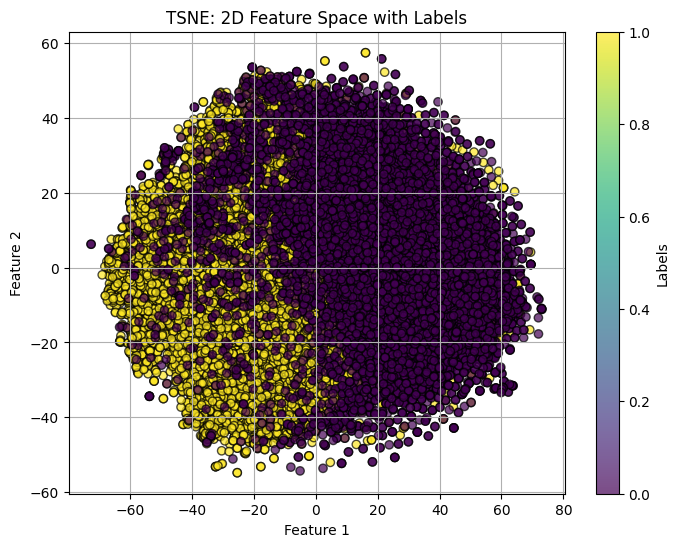

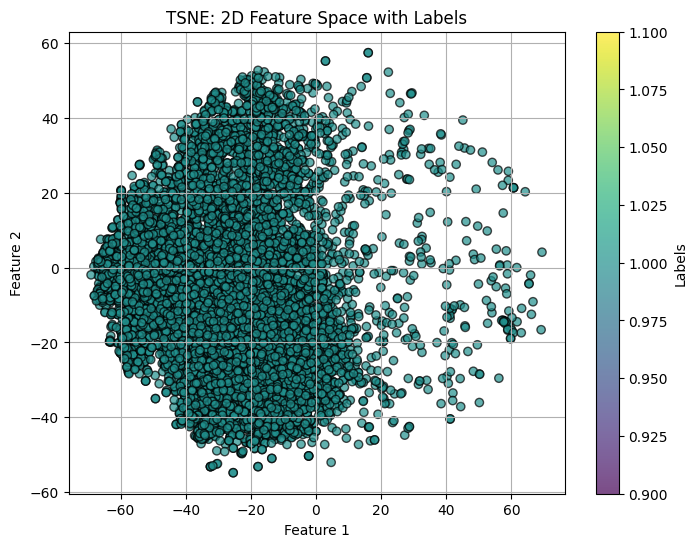

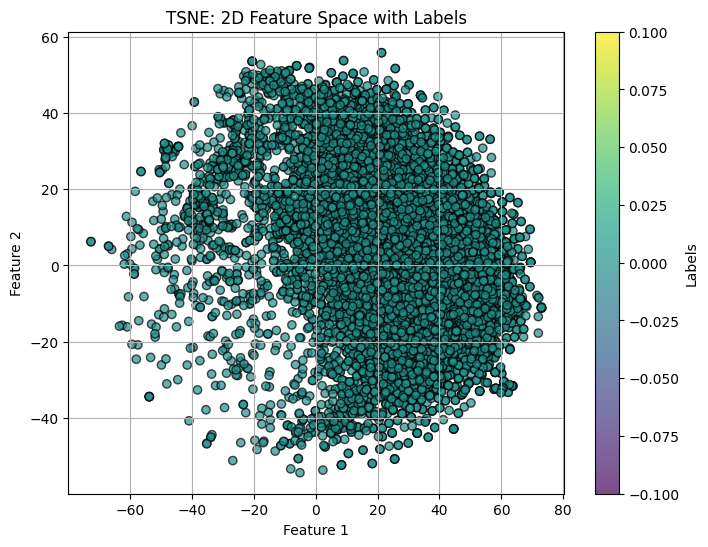

In [ ]:
plot_examples(X_embedded_complex, y) # Positive and Negative Labels

X_positive = X_embedded_complex[y == 1]
y_positive = y[y == 1]
plot_examples(X_positive, y_positive) # Positive Labels

X_negative = X_embedded_complex[y == 0]
y_negative = y[y == 0]
plot_examples(X_negative, y_negative) # Negative Labels

## Observations for k = 4 and larger TSNE parameters


*   The overall shape of the combined plot still resembles a ball, which suggests the lack of binary clusters.
*   The presence of a dense cloud with sparse outliers suggests the need to test k = 6 in addition to the TSNE parameters.
*   Similar levels of evidence of a clear decision boundary can be observed.

In [ ]:
# Experiment with various parameters such as changing the k-value, perplexity, and early exaggeration.
X6, kmer_list6, y6 = encoding_4mer_6mer(6)
X_embedded_complex6 = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=30, early_exaggeration=12).fit_transform(X6)

Frequency Distribution Vector of a Given Sequence:
CAAGTA = 0.0040650406504065045
AAGTAT = 0.008130081300813009
AGTATC = 0.0040650406504065045
GTATCC = 0.0040650406504065045
TATCCT = 0.0040650406504065045
ATCCTA = 0.0040650406504065045
TCCTAC = 0.0040650406504065045
CCTACA = 0.0040650406504065045
CTACAT = 0.0040650406504065045
TACATA = 0.0040650406504065045
ACATAG = 0.0040650406504065045
CATAGA = 0.0040650406504065045
ATAGAT = 0.0040650406504065045
TAGATT = 0.0040650406504065045
AGATTA = 0.0040650406504065045
GATTAT = 0.0040650406504065045
ATTATA = 0.0040650406504065045
TTATAG = 0.0040650406504065045
TATAGG = 0.0040650406504065045
ATAGGA = 0.0040650406504065045
TAGGAG = 0.0040650406504065045
AGGAGT = 0.0040650406504065045
GGAGTG = 0.0040650406504065045
GAGTGA = 0.0040650406504065045
AGTGAC = 0.0040650406504065045
GTGACC = 0.0040650406504065045
TGACCG = 0.0040650406504065045
GACCGC = 0.0040650406504065045
ACCGCA = 0.0040650406504065045
CCGCAA = 0.0040650406504065045
CGCAAA = 0.004065040

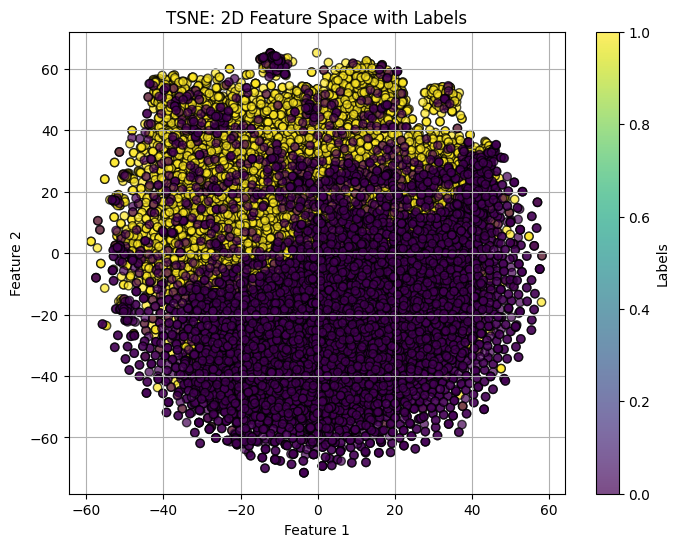

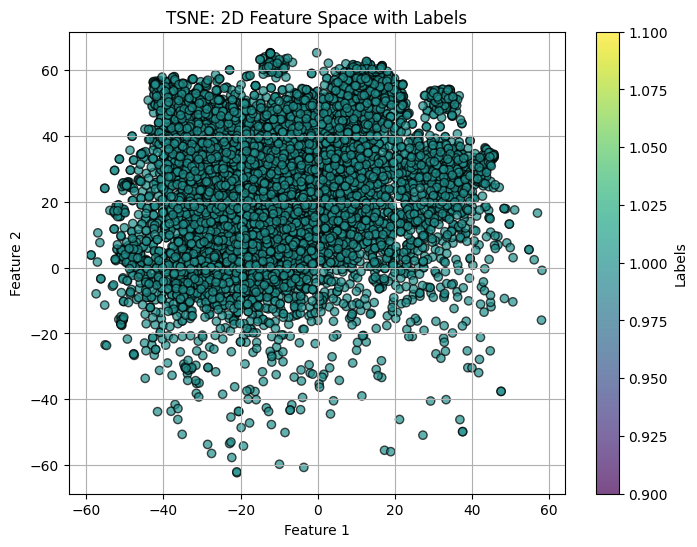

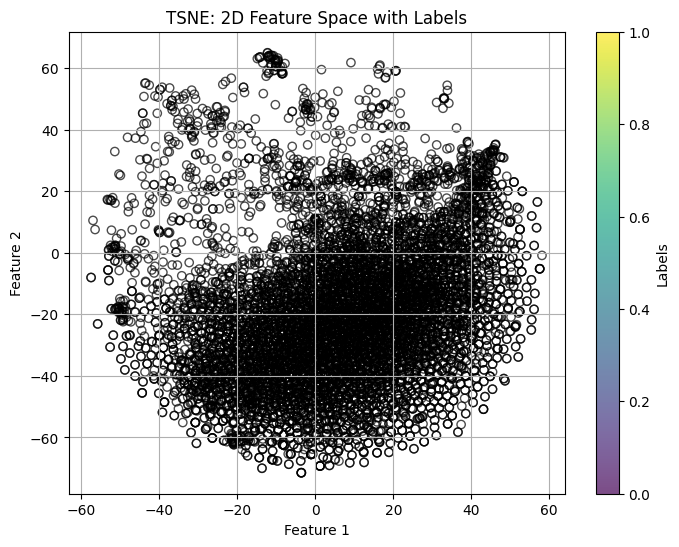

In [ ]:
plot_examples(X_embedded_complex6, y6) # Positive and Negative Labels

X_positive = X_embedded_complex6[y6 == 1]
y_positive = y6[y6 == 1]
plot_examples(X_positive, y_positive) # Positive Labels

X_negative = X_embedded_complex6[y6 == 0]
y_negative = y6[6 == 0]
plot_examples(X_negative, y_negative) # Negative Labels

## Observations for k = 6 and larger TSNE parameters


*   Observations regarding the shape of the combined, positive, and negative classes remain largely the same, as shown by the presence of a large ball separated into "two halves".
*   It can be hypothesized that the essence of the underlying data complexity is significantly underestimated.
*   Perhaps more sofisticated feature selection methods and alternative data visualization techniques are needed to arrive at a higher-fidelity separation of the positive and negative classes.
*   However, if the evidence from the plots above can be inferred to be sufficient for categorizing the shape and 2-D distribution of the binary classes as already having two distinct clusters, then the classification problem should proceed smoothly.

# Data Partitioning


*   Train and test split using the 20% threshold
*   Feature normalization may be employed.
*   The X features are consistent with the representation of 256 different kmers instead of the truncated two-dimensional X_embedded features processed by TSNE.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X, kmer_list, y = encoding_4mer_6mer(4) # Obtain encoded X and y ndarrays when k = 4

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Frequency Distribution Vector of a Given Sequence:
CAAG = 0.004032258064516129
AAGT = 0.016129032258064516
AGTA = 0.008064516129032258
GTAT = 0.012096774193548387
TATC = 0.008064516129032258
ATCC = 0.012096774193548387
TCCT = 0.008064516129032258
CCTA = 0.004032258064516129
CTAC = 0.004032258064516129
TACA = 0.012096774193548387
ACAT = 0.008064516129032258
CATA = 0.008064516129032258
ATAG = 0.008064516129032258
TAGA = 0.008064516129032258
AGAT = 0.008064516129032258
GATT = 0.004032258064516129
ATTA = 0.004032258064516129
TTAT = 0.004032258064516129
TATA = 0.020161290322580645
TAGG = 0.004032258064516129
AGGA = 0.004032258064516129
GGAG = 0.004032258064516129
GAGT = 0.012096774193548387
AGTG = 0.020161290322580645
GTGA = 0.012096774193548387
TGAC = 0.008064516129032258
GACC = 0.008064516129032258
ACCG = 0.004032258064516129
CCGC = 0.004032258064516129
CGCA = 0.004032258064516129
GCAA = 0.004032258064516129
CAAA = 0.012096774193548387
AAAA = 0.03225806451612903
AAAC = 0.00806451612903225

# Training and Testing


*   Train the logistic regression
*   Test and measure the performance on the test set.
*   Analyze the metrics using precision, recall, f1-score, and the confusion matrix.

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf = clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1733
           1       0.91      0.91      0.91      1480

    accuracy                           0.92      3213
   macro avg       0.91      0.91      0.91      3213
weighted avg       0.92      0.92      0.92      3213



In [ ]:
(clf.coef_.shape, clf.intercept_.shape)

((1, 256), (1,))

In [ ]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test,y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('True Positives:', tp)
print('True Negatives:', tn)
print('False Positives:', fp)
print('False Negatives:', fn)

[[1593  140]
 [ 133 1347]]
True Positives: 1347
True Negatives: 1593
False Positives: 140
False Negatives: 133


## Discussion

While the overall accuracy remains very high at 0.92, the precision and recall are also superb. The tallies from the support and the confusion matrix are hard evidence that logistic regression suits the machine learning problem of this assignment very well. It is also important to note that the 4-mer tokenization of the dataset seems to allow the model to behave effectively, allowing logistic regression to identify decision boundaries based on the presence or absence of certain kinds of 4-mers. This is likely due to the robustness of the algorithm in response to large datasets with high dimensionality.

The next steps will involve alternative encoding techniques and evaluating the performance of more sofisticated machine learning algorithms.